# Importación de librerías

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # esto es para que no aparezcan las advertencias en las líneas de código


Se carga el archivo .parquet previamente cargado en etl.py

In [29]:
df = fastparquet.ParquetFile('steam_games.parquet').to_pandas()

Se observan los datos

In [30]:
df.head()

,publisher,genres,title,release_date,tags,specs,price,early_access,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018.0,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0,Kotoshiro,sin_calificar,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,2018.0,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",NaN,0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017.0,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",NaN,0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,2017.0,"[Action, Adventure, Casual]",[Single-player],0.99,0,彼岸领域,sin_calificar,NaN
4,None,None,None,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0,None,sin_calificar,NaN


Se desanidan las columnas que contienen listas

In [31]:
# Se desanidan las listas en las columnas "genres" y "specs"
df["genres"] = df["genres"].explode().reset_index(drop=True)
df["specs"] = df["specs"].explode().reset_index(drop=True)
df["tags"] = df["tags"].explode().reset_index(drop=True)


Se observa en qué formato se encuentra cada columna del dataframe

In [32]:
df.dtypes

publisher        object
genres           object
title            object
release_date    float64
tags             object
specs            object
price           float64
early_access      int32
developer        object
sentiment        object
metascore       float64
dtype: object

Se visualizan las fechas mínima y máxima de los datos

In [33]:
#fecha mínima y máxima en la columna "release_date"
print(df['release_date'].min())
print(df['release_date'].max())

1970.0
2021.0


Se observa que sería más conveniente considerar un intervalo temporal más próximo, en este caso desde el año 2010 en adelante

In [34]:
# Se filtran las filas donde la fecha sea desde el año 2010 en adelante
df= df.loc[df['release_date'] >= 2010]

Se verá cuántos nulos tiene cada columna del dataset.

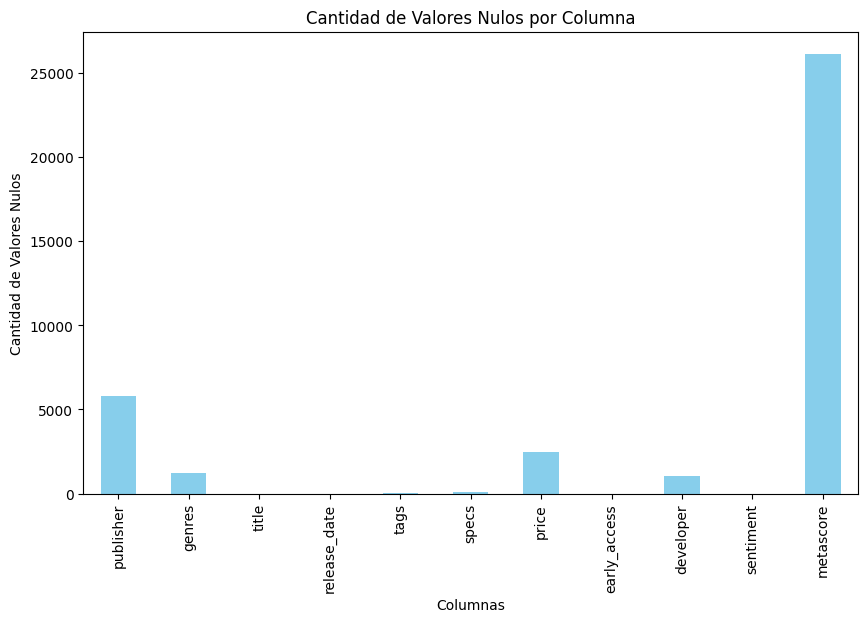

In [35]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6)) #tamaño del gráfico
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)  # se visualizan las barras de forma vertical
plt.show()

Se reduce el dataset a los registros que no tengan valores nan en la columna price, dado que esta es la variable que se pretende predecir.

In [36]:
df_sin_nans = df.dropna(subset=["price"])
df=df_sin_nans

A continuación se muestra un gráfico de cajas para los datos de la columna target "price"

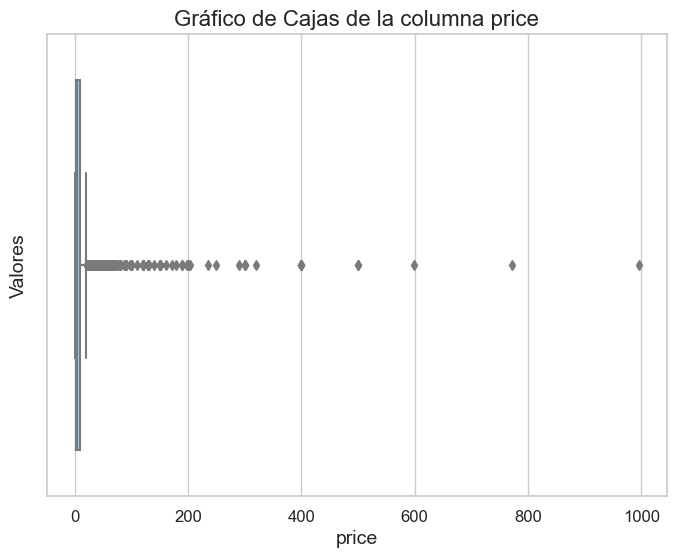

In [37]:

sns.set(style='whitegrid')  # cuadrícula blanca

# gráfico de cajas
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["price"], palette='pastel')  # Color
plt.title(f'Gráfico de Cajas de la columna {"price"}', fontsize=16)
plt.xlabel("price", fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Del gráfico anterior se observa la presencia de outliers, se verá cuántos datos de este tipo hay en el dataset para determinar si se deberían considerar o no. Para esto es necesario conocer los valores de los cuartiles. 

In [38]:
Q1 = np.percentile(df["price"], 25)  # Primer cuartil (25%)
Q3 = np.percentile(df["price"], 75)  # Tercer cuartil (75%)
IQR = Q3 - Q1

infimo = Q1 - 1.5 * IQR
supremo = Q3 + 1.5 * IQR

print(f"Primer Cuartil (Q1): {Q1}")
print(f"Tercer Cuartil (Q3): {Q3}")
print(f"Rango Intercuartil (IQR): {IQR}")
print(f"Límite Inferior para Outliers: {infimo}")
print(f"Límite Superior para Outliers: {supremo}")

outliers = df[(df["price"] < infimo) | (df["price"] > supremo)]
min_outlier = outliers["price"].min()

print(f"Valor mínimo para considerar outliers: {min_outlier}")


Primer Cuartil (Q1): 2.99
Tercer Cuartil (Q3): 9.99
Rango Intercuartil (IQR): 7.0
Límite Inferior para Outliers: -7.51
Límite Superior para Outliers: 20.490000000000002
Valor mínimo para considerar outliers: 20.99


Se observa que:
- El 50% de los datos se encuentra concentrado en un rango de 7 unidades.
- El límite inferior (infimo) del rango intercuartil es negativo, por lo que hay que observar adecuadamente los valores de la columna price.

In [39]:
positivos = (df["price"] > 0).sum()
negativos = (df["price"] < 0).sum()

print(f"Número de valores positivos: {positivos}")
print(f"Número de valores negativos: {negativos}")


Número de valores positivos: 25610
Número de valores negativos: 0


Dado que no se encuentran valores negativos en la columna "price", se entiende que esto es simplemente porque la mayoría de los valores án cerca de 0, sería entendible que el límite inferior del rango intercuartil pueda ser negativo, aunque no exista ningún valor del dataset que sea negativo.

Se verá ahora cuántos datos aparecen en el dataset mayores que 22, dado que a partir de aquí aparecen los outliers según la tabla anterior.

In [40]:
mayores_22= (df["price"] > 22).sum()
print(f"Número de datos mayores que 22 en la columna 'price': {mayores_22}")

Número de datos mayores que 22 en la columna 'price': 1731


Se visualiza la cantidad de registros del dataset y se divide el total de filas por el total de outliers que se encuentra en el dataset para ver si es relevante el porcentaje en cuanto a frecuencia.

In [41]:
df.shape

(25610, 11)

In [42]:
1731/29392 *100

5.889357648339684

La cantidad de outliers representa aproximadamente el 5.8% de los datos totales, se considerará eliminar estos valores.

In [43]:
df = df[df["price"] <= 22]

A continuación se visualiza de nuevo un gráfico de cajas para observar la distribución de los datos de la columna "price", sin los outliers anteriores.

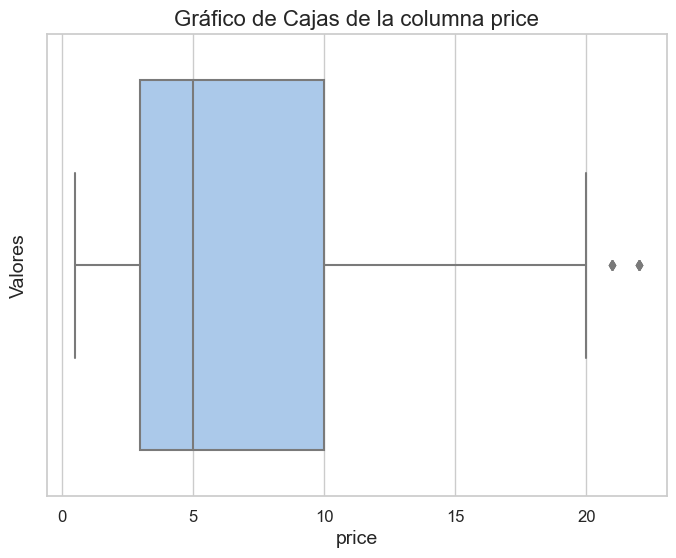

In [44]:

sns.set(style='whitegrid')  # Estilo de cuadrícula blanca

# gráfico de cajas
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["price"], palette='pastel')  # Paleta de colores suaves
plt.title(f'Gráfico de Cajas de la columna {"price"}', fontsize=16)
plt.xlabel("price", fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Aquí se corrobora que el 50% de los datos están entre el rango 2 y 10. El 70% de los precios son menores que 20 usd.

Se analiza la columna "metascore"

In [45]:
print(df["metascore"].unique())   # se corrobora cuáles son las etiquetas

[nan 68. 66. 78. 76. 70. 53. 79. 63. 72. 64. 56. 75. 61. 67. 83. 49. 38.
 81. 85. 82. 52. 71. 65. 62. 84. 80. 77. 59. 74. 48. 87. 69. 34. 95. 43.
 54. 57. 73. 51. 60. 55. 92. 24. 46. 86. 58. 91. 44. 88. 41. 20. 39. 45.
 47. 40. 36. 90. 93. 50. 89. 32. 37. 42. 94.]


A simple vista no se encuentra algún tipo de columna del dataset que explique los valores nan de la columna "metascore". Por tal motivo esta se eliminará.

In [46]:
df.drop(columns=["metascore"],inplace=True) # se elimina dicha columna

En el primer proceso de etl se cambiaron los valores nan por la categoría "sin_calificar"

In [47]:
print(df["sentiment"].unique())  # se corrobora cuáles son las etiquetas

['sin_calificar' 'Mixed' '1 user reviews' '3 user reviews'
 'Mostly Positive' '6 user reviews' '5 user reviews' '2 user reviews'
 'Positive' 'Very Positive' '8 user reviews' 'Overwhelmingly Positive'
 'Mostly Negative' '4 user reviews' '7 user reviews' '9 user reviews'
 'Very Negative' 'Overwhelmingly Negative' 'Negative']


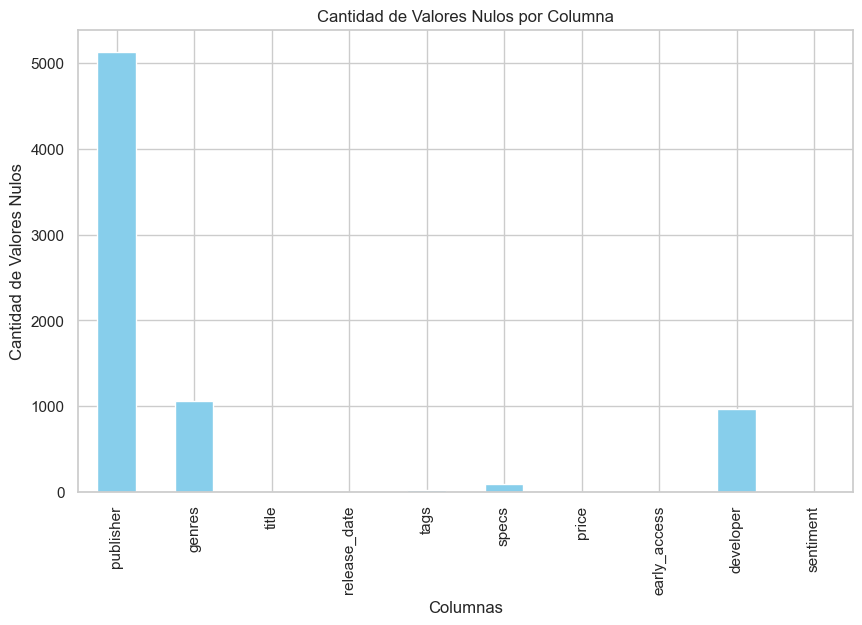

In [48]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6))  # Dimensiones del gráfico
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)  # barras verticaes
plt.show()

Se verificará qué porcentaje de nans se encuentra en la columna "publisher", dado que aparece una gran cantidad de ellos. Por tal motivo, se verá si es conveniente comenzar filtrando nans a través de esta misma columna.

In [49]:
porcentaje_nulos = (df["publisher"].isnull().sum() / len(df["publisher"])) * 100
print(f"Porcentaje de valores nulos en la columna 'publisher': {porcentaje_nulos:.2f}%")

Porcentaje de valores nulos en la columna 'publisher': 21.50%


Se elimina el subconjunto de registros donde la columna "publisher" contiene valores nulos. Se continúa haciendo esto con las demás columnas.

In [50]:
df.dropna(subset=["publisher"],inplace=True)

Se hará lo mismo con el resto de las columnas que contienen nans, según lo observado en el gráfico anterior.

In [51]:
df.dropna(subset=["genres"],inplace=True)

In [52]:
df.dropna(subset=["developer"],inplace=True)

In [53]:
df.dropna(subset=["publisher"],inplace=True)

In [54]:
df.dropna(subset=["genres"],inplace=True)

In [55]:
df.dropna(subset=["specs"],inplace=True)

In [56]:
df.dropna(subset=["tags"],inplace=True)

Se corrobora una vez más la cantidad de valores nan que aparecen en las columnas.

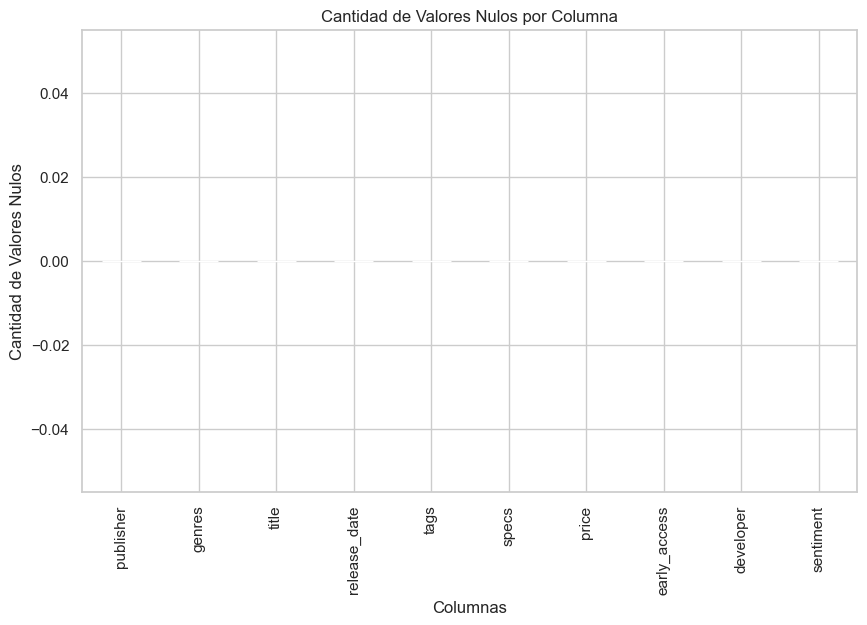

In [57]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)
plt.show()

Para conocer mejor el dataset, se visualizará un heatmap ( mapa de calor ) . Esto es para ver si existe alguna correlación entre columnas del dataset.

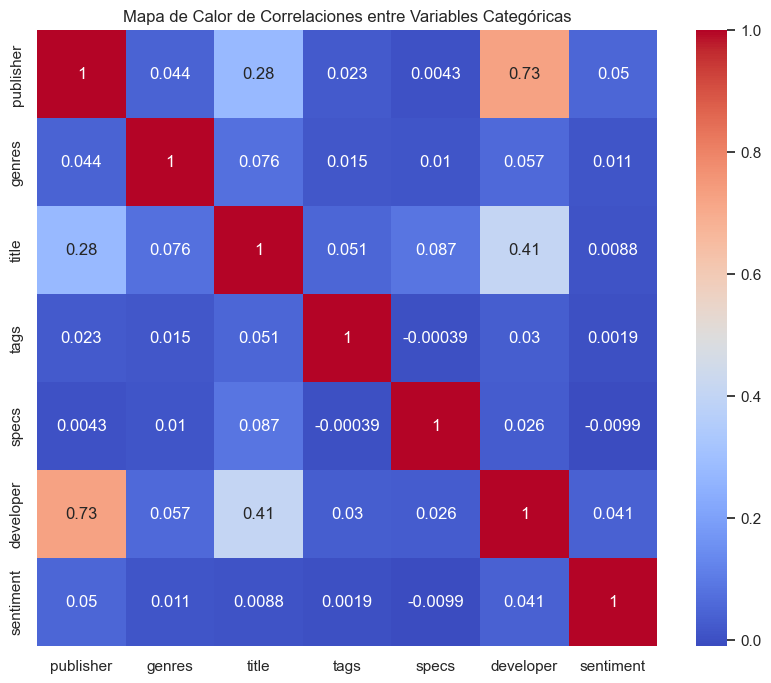

In [58]:

# Calcular la matriz de correlaciones entre variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
correlation_matrix = df[categorical_columns].apply(lambda x: x.factorize()[0]).corr()

# Crear un mapa de calor de las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Mapa de Calor de Correlaciones entre Variables Categóricas')
plt.show()



Parecen no haber variables fuertemente correlacionadas, salvo publisher y developer. De momento no se eliminará ninguna columna, si bien se podría considerar eliminar "publisher" o "developer", es decir , dejar alguna de esas dos, por su alto grado de correlación.

Se separa el conjunto target "y" del resto de las variables del dataset "X".

In [59]:
X=df.drop("price",axis=1)
y=df['price']

Se eliminará la columna "title" en este caso para simplificar el modelo, también pensando en que el sentido común indica que aparentemente no hay una relación directa entre el título que ponga la persona y la predicción del precio. ( tal vez si la haya, pero en este caso no se estudiará ese caso ).

In [60]:
X=X.drop("title",axis=1)

Lo siguinte será codificar los datos, hay 3 posibilidades:

- Label encoding: Se intentará establecer orden de jerarquías con cada etiqueta. La cantidad de columnas sigue siendo la misma. Esto es una ventaja computacionalmente hablando.

- Get dummies ( One hot encoding): Si bien tal vez este método sería el más adecuado, el problema es que se generan muchas columnas y la pc que se está utilizando es limitada en recuersos computacionales.

- Integer encoding: Por falta de tiempo no se pudo analizar esta opción, la cual podría haber sido considerada dado que, a diferencia de label encoding, no asume jerarquías de las etiquetas.

Columnas a codificar.

In [61]:
#Lista de columnas a las que se aplicará  Encoding
columnas = ["publisher","genres", "tags", "specs","sentiment","developer","release_date"]

# Label encoder

In [62]:
# Se crea un objeto LabelEncoder
label_encoder = LabelEncoder()

# Se aplica LabelEncoder a las columnas seleccionadas
for col in columnas:
    X[col] = label_encoder.fit_transform(X[col])


# Test de distribución normal de los datos

Para ver si es posible aplicar un algoritmo de regresión lineal, primero se verá si se cumple una de sus hipótesis: las distribuciones de los datos debe ser normal. Se aplicará para esto, el test de Shapiro-Wilk.

In [63]:
from scipy.stats import shapiro

# Realizar el test de normalidad de Shapiro-Wilk para cada columna
normality_results = {}
for column in X.columns:
    stat, p_value = shapiro(X[column])
    normality_results[column] = {'statistic': stat, 'p-value': p_value}

# Imprimir los resultados del test
for column, result in normality_results.items():
    print(f"Column: {column}")
    print(f"Shapiro-Wilk Statistic: {result['statistic']:.4f}")
    print(f"P-value: {result['p-value']:.4f}")
    print("Is Normally Distributed: ", result['p-value'] > 0.05)
    print("=" * 40)



Column: publisher
Shapiro-Wilk Statistic: 0.9452
P-value: 0.0000
Is Normally Distributed:  False
Column: genres
Shapiro-Wilk Statistic: 0.9129
P-value: 0.0000
Is Normally Distributed:  False
Column: release_date
Shapiro-Wilk Statistic: 0.8452
P-value: 0.0000
Is Normally Distributed:  False
Column: tags
Shapiro-Wilk Statistic: 0.9276
P-value: 0.0000
Is Normally Distributed:  False
Column: specs
Shapiro-Wilk Statistic: 0.8254
P-value: 0.0000
Is Normally Distributed:  False
Column: early_access
Shapiro-Wilk Statistic: 0.2593
P-value: 0.0000
Is Normally Distributed:  False
Column: developer
Shapiro-Wilk Statistic: 0.9513
P-value: 0.0000
Is Normally Distributed:  False
Column: sentiment
Shapiro-Wilk Statistic: 0.8960
P-value: 0.0000
Is Normally Distributed:  False


Dado que las columnas del dataframe no siguen una distribución normal, se descarta automáticamente utilizar el método de  regresión multilineal.

# Estandarización de los datos

Se estandarizan los datos par tener una mejor visualización de los mismos y sobre todo para poder obtener una mejor performance de los algoritmos de machine learning.

In [64]:
# Se estandarizan los datos utilizando StandardScaler
scaler = StandardScaler()
X_n = scaler.fit_transform(X)

# Se convierte el arreglo numpy a un DataFrame de pandas, manteniendo el nombre de las columnas
X = pd.DataFrame(data=X_n, columns=X.columns)

Una vez estandarizado el dataset, se puede apreciar mejor, por ejemplo un gráfico de cajas , para observar la variabilidad de los datos

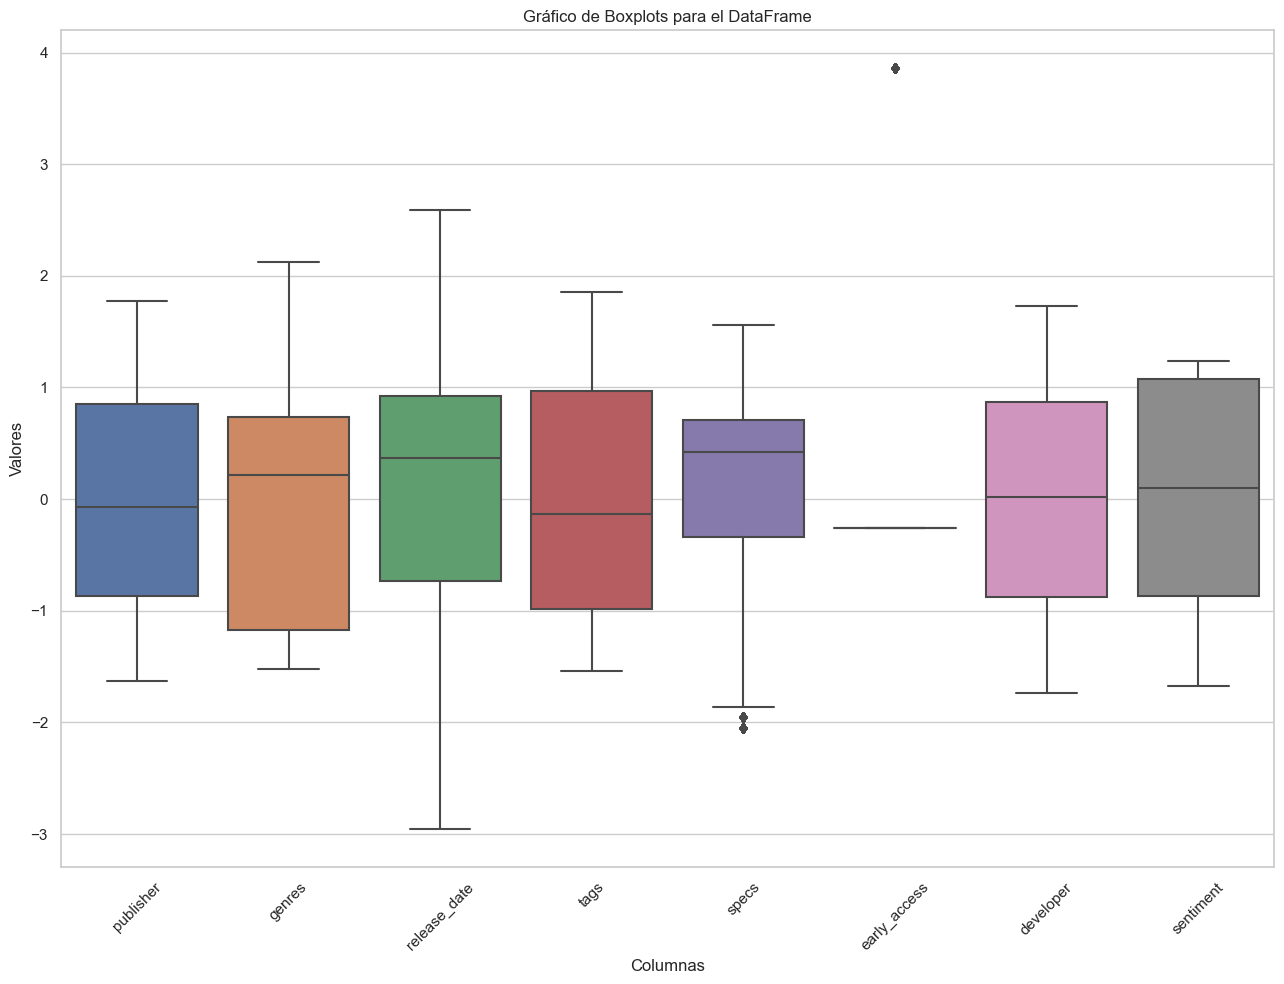

In [65]:
# Se definen los nombres de las columnas que se visualizarán
columnas = ["publisher","genres", "release_date", "tags", "specs", "early_access", "developer", "sentiment"]

# Crear un gráfico de boxplots
plt.figure(figsize=(13, 10))
sns.boxplot(data=X_n)
plt.title('Gráfico de Boxplots para el DataFrame')
plt.xlabel('Columnas')
plt.ylabel('Valores')
plt.xticks(range(len(columnas)), columnas, rotation=45)
plt.tight_layout()
plt.show()


- Se observa que existe mucha variabilidad en los datos de cada columna, sobre todo en las fechas.
- La columna "early_acces" contiene outliers. Esta columna debería tener únicamente valores 0 y 1. Más adelante se determinará qué columnas se eliminarán.

Get dummies.

Dado que el dataset resultante de aplicar get dummies es muy grande y consume una cantidad de recursos computacionales considerable, se ha decidido descartar esta posibilidad aunque se comprende que tal vez sería lo más adecuado.

In [66]:
#One-Hot Encoding a las columnas seleccionadas
#df_codif = pd.get_dummies(X, columns=columnas)

#Se muestra el nuevo DataFrame con las columnas codificadas
#print(df_encoded.head())
#Xg=df_codif

# Regresión polinómica

Se probó con distintos grados, en este caso el que mejor métricas presentó fue para n=3

In [44]:

# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se crean características polinómicas
degree = 3  # Grado del polinomio
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Se crea el modelo de Regresión Lineal
model = LinearRegression()

# Se ajusta el modelo a los datos de entrenamiento
model.fit(X_train_poly, y_train)

# Se realizan las  predicciones en el conjunto de prueba
y_pred_test = model.predict(X_test_poly)
y_pred_train = model.predict(X_train_poly)

# Se calculan las métricas del modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Se muestran las métricas en el conjunto de entrenamiento
print("Métricas en el conjunto de entrenamiento:")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"R-squared (R2): {r2_train:.2f}")
print()


# Se calculan las  métricas del modelo
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Se imprimen las métricas para el conjunto de prueba
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Métricas en el conjunto de entrenamiento:
Mean Squared Error (MSE): 27.68
Mean Absolute Error (MAE): 4.24
R-squared (R2): 0.08

Mean Squared Error (MSE): 27.50
Root Mean Squared Error (RMSE): 5.24
Mean Absolute Error (MAE): 4.27
R-squared (R2): 0.06


- No hay mucha variabilidad en cuando a los scores del conjunto de entrenamiento y prueba.

Respecto al conjunto de prueba:
- El R-squared indica que el 6% de la variable target y es explicada por las características en este modelo. 
- El RMSE indica que el modelo presenta una desviación típica de los datos de 5.24.
- El MAE indica que la magnitud promedio entre los valores predichos y reales es de 4.27. Este valor es más bajo que el RMSE ya que no se ve tan afectado por valores alejados de la media ( se recuerda que se eliminaron los outliers de la columna "price" del dataset )

# Importancia de las variables con random forest

Se verá qué columnas presentan características más importantes para el modelo random forest.

In [45]:
# Se crea el modelo de Random Forest
model = RandomForestRegressor(random_state=42)

# Se ajusta el modelo a los datos
model.fit(X, y)

# importancia relativa de las características
feature_importances = model.feature_importances_

# Se crea un DataFrame para mostrar las importancias
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

# Se ordena el DataFrame por importancia en orden descendente
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Se calcula el porcentaje acumulado de importancia
importance_df["Cumulative Importance"] = importance_df["Importance"].cumsum()

# Se muestra el dataFrame creado con los datos anteriores
print(importance_df)


        Feature  Importance  Cumulative Importance
0     publisher    0.285321               0.285321
6     developer    0.197044               0.482365
3          tags    0.141704               0.624069
7     sentiment    0.112198               0.736267
4         specs    0.099596               0.835863
1        genres    0.082835               0.918698
2  release_date    0.065489               0.984187
5  early_access    0.015813               1.000000


Esta tabla muestra la importancia de las características del dataset , según el modelo random forest. Se podrían eliminar las columnas "genres" "release_date" y "early_access". Esto no se hará de momento.

# Decision tree

Se verá cuáles son los mejores hiperparámetros para el modelo decision tree.

In [53]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se definen los hiperparámetros a explorar en la búsqueda en cuadrícula
grilla = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Se crea el modelo Decision tree
model = DecisionTreeRegressor(random_state=42)

# Se realiza la búsqueda en la grilla con cross validation
grid_search = GridSearchCV(model, grilla, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Se obtiene el mejor modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores hiperparámetros:")
print(best_params)

# Se realizan predicciones en el conjunto de entrenamiento
y_pred_train = best_model.predict(X_train)

# Se calculan métricas del modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Se muestran las métricas en el conjunto de entrenamiento
print("Métricas en el conjunto de entrenamiento:")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"R-squared (R2): {r2_train:.2f}")
print()

# Se realizan predicciones en el conjunto de prueba
y_pred_test = best_model.predict(X_test)

# Se calculan métricas del modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Se imprimen las métricas en el conjunto test ( conjunto de prueba )
print("Métricas en el conjunto de prueba:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"R-squared (R2): {r2_test:.2f}")


Mejores hiperparámetros:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Métricas en el conjunto de entrenamiento:
Mean Squared Error (MSE): 20.52
Mean Absolute Error (MAE): 3.46
R-squared (R2): 0.32

Métricas en el conjunto de prueba:
Mean Squared Error (MSE): 24.80
Mean Absolute Error (MAE): 3.85
R-squared (R2): 0.15


Mejores hiperparámetros:
'max_depth': 10
'min_samples_leaf'
4, 'min_samples_split': 10  

# K-means

Se intentará ver si es posible separar los datos en clusters. La intención es ver si es posible obtener otras etiquetas que ayuden a obtener mejores resultados para posteriormente aplicar algoritmos de regresión.

c:\Users\Outlet VL\Desktop\programación\henry\Labs\semana_1\proyecto_semana1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.26
Inertia: 87372.85


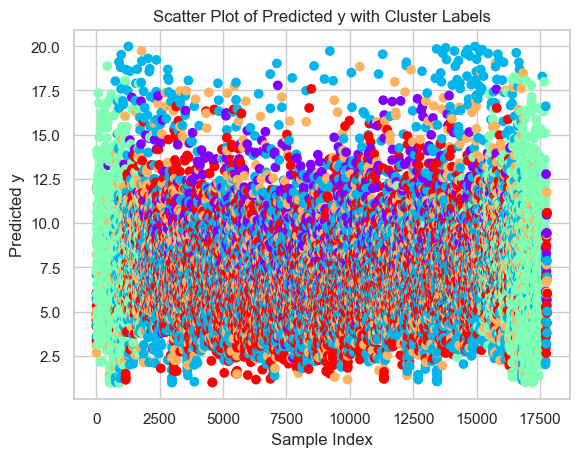

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Se crea una instancia del algoritmo KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)  # X es tu conjunto de datos

# Se agregan etiquetas de cluster como nueva columna en el DataFrame original
X["cluster_label"] = cluster_labels

# Se define el modelo de Random Forest
model = RandomForestRegressor(n_estimators=50, random_state=42)

# Se realizan predicciones utilizando validación cruzada
y_pred = cross_val_predict(model, X, y, cv=5)

# Se calcula el Silhouette Score
silhouette_avg = silhouette_score(X, cluster_labels)

# Se calcula la inercia (Within-cluster sum of squares)
inertia = kmeans.inertia_

# Se muestra el Silhouette Score y la inercia
print(f'Silhouette Score: {silhouette_avg:.2f}')
print(f'Inertia: {inertia:.2f}')

# Se crea un nuevo DataFrame con las etiquetas de cluster
cluster_df = pd.DataFrame({"cluster_label": cluster_labels})

# Se concatenan el nuevo DataFrame con el DataFrame original
new_dataset = pd.concat([X, cluster_df], axis=1)

# Se crea un gráfico de dispersión de los datos coloreado por etiquetas de clúster
plt.scatter(X.index, y_pred, c=cluster_labels, cmap='rainbow')
plt.xlabel('Sample Index')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Predicted y with Cluster Labels')
plt.show()


 - El valor alto de inercia (de 87372.85) muestra que los clusters están muy poco separados y no compactos en general.
- El valore de Silhouette Score de 0.26 evidencia la superposición de los clusters, como se ve en el gráfico.

Se concluye que el modelo k-means no es bueno para intentar generar etiquetas nuevas de los datos.

# PCA

Se aplicará PCA con la intención de buscar las características más importantes del dataset, y ver si es factible hacer una reducción de dimensionalidad. Esto es con la intención de captar las características más importantes del dataset para posteriormente aplicar modelos de regresión sobre las componentes principales.

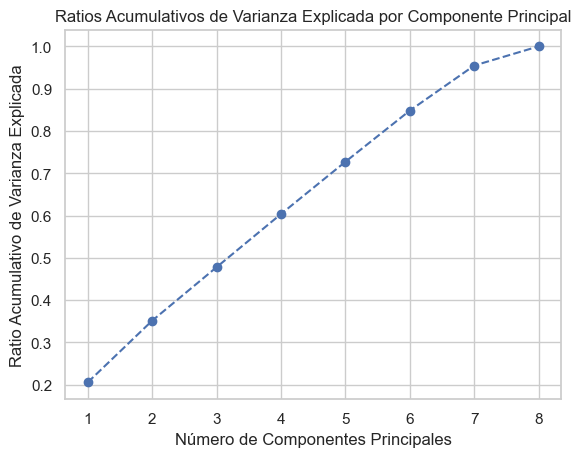

Componente Principal 1: Ratio Acumulativo de Varianza Explicada = 0.2054
Componente Principal 2: Ratio Acumulativo de Varianza Explicada = 0.3513
Componente Principal 3: Ratio Acumulativo de Varianza Explicada = 0.4778
Componente Principal 4: Ratio Acumulativo de Varianza Explicada = 0.6035
Componente Principal 5: Ratio Acumulativo de Varianza Explicada = 0.7271
Componente Principal 6: Ratio Acumulativo de Varianza Explicada = 0.8481
Componente Principal 7: Ratio Acumulativo de Varianza Explicada = 0.9547
Componente Principal 8: Ratio Acumulativo de Varianza Explicada = 1.0000
Número de componentes para explicar al menos 95.0% de varianza acumulada: 7


In [44]:

# Se crea una instancia del modelo
pca = PCA()  

#Se ajusta el modelo al conjunto X

X_pca = pca.fit_transform(X)

# Gráfico de los ratios acumulativos de varianza explicada por cada componente principal
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Ratio Acumulativo de Varianza Explicada')
plt.title('Ratios Acumulativos de Varianza Explicada por Componente Principal')
plt.show()

# Se muestran los ratios de varianza acumulados
for i, cum_ratio in enumerate(cumulative_variance_ratio, start=1):
    print(f'Componente Principal {i}: Ratio Acumulativo de Varianza Explicada = {cum_ratio:.4f}')

# Se calcula la cantidad de componentes necesarias para explicar cierto porcentaje de varianza
threshold_cumulative_variance = 0.95  # Cambia este valor según tus necesidades
num_components_needed = next(i for i, cum_ratio in enumerate(cumulative_variance_ratio) if cum_ratio >= threshold_cumulative_variance) + 1
print(f'Número de componentes para explicar al menos {threshold_cumulative_variance * 100:.1f}% de varianza acumulada: {num_components_needed}')




Se observa, por ejemplo, que 7 componentes o autovectores encontrados explican más del 95 % de los datos, con 6 componentes se obtiene más del 85% de los mismos. Se considera entonces que no es muy conveniente aplicar este método en este caso dado que se necesitan casi la misma cantidad de variables que se están manejando sin aplicar este método.

# Random forest

Se puede aplicaá una grilla para ajustar hiperparámetros que mejor se ajusten al modelo de random forest.

Se utilizará una grilla con crossvalidación

In [ ]:
# Se crea  y entrena el modelo de Random Forest
model = RandomForestRegressor()

# Se divien los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se define la cuadrícula de hiperparámetros a probar
param_grid = {
    'n_estimators': [ 20, 50, 100],
    'max_depth': [None, 10, 15, 25],
}

# Se realiza la búsqueda de parámetros utilizando GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Se obtienen los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Se realizan predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)


# Se muestran los mejores parámetros
print("Mejores parámetros:", best_params)


Error cuadrático medio en el conjunto de prueba: 23.938353886225254
Mejores parámetros: {'max_depth': 15, 'n_estimators': 50}


Se aplican estos parámetros al modelo

In [ ]:
# Se dividen los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se crea la instancia del modelo Random Forest y se entrena

model = RandomForestRegressor(n_estimators=50,max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Se realizan predicciones en el conjunto de prueba y se guardan
y_pred = model.predict(X_test)

# Métricas 
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Se imprimen las métricas
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')



Mean Squared Error (MSE): 24.13
Mean Absolute Error (MAE): 3.91
R-squared (R2): 0.17
Adjusted R-squared: 0.17
Adjusted R-squared: 0.17


# SVR

Se intentará determinar qué nucleo es más conveniente utilizar para este dataset con el modelo de máquinas de soporte vectorial, como regresor.

In [46]:
from sklearn.svm import SVR

# Supongamos que tienes tu conjunto de datos X y y

# Definir los parámetros a buscar en la búsqueda de hiperparámetros
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Crear el modelo de SVR
model = SVR()

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Realizar la búsqueda de hiperparámetros en los datos normalizados
grid_search.fit(X, y)

# Mostrar los mejores parámetros y el mejor score obtenido
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor MSE:", -grid_search.best_score_)



Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor MSE: 30.816651456100004


# Gradient Boosting Regressor

Se genera una grilla para buscar los mejores hiperparámetros.

In [62]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se definen los hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Se crea una instancia del modelo de Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Se realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Se obtiene el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Se realizan predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Se calculan métricas del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas y los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Mean Squared Error (MSE): 20.48
Mean Absolute Error (MAE): 3.52
R-squared (R2): 0.30


# Mejor modelo

Finalmente se intentará ver qué modelo podría ofrecer mejores métricas, se compararán "linear Regression", "SVR",  "Random forest (como regersor ) y Gradient Boosting.

Model: SVR
Mean Squared Error (MSE): 30.05
Root Mean Squared Error (RMSE): 5.48
Mean Absolute Error (MAE): 4.12
R-squared (R2): -0.03


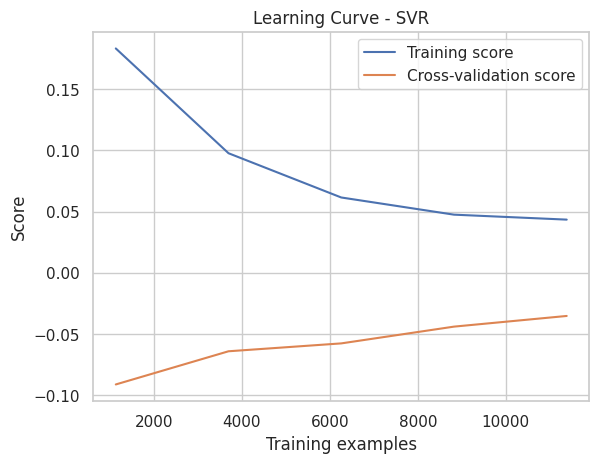

Model: DecisionTreeRegressor
Mean Squared Error (MSE): 24.76
Root Mean Squared Error (RMSE): 4.98
Mean Absolute Error (MAE): 3.84
R-squared (R2): 0.15


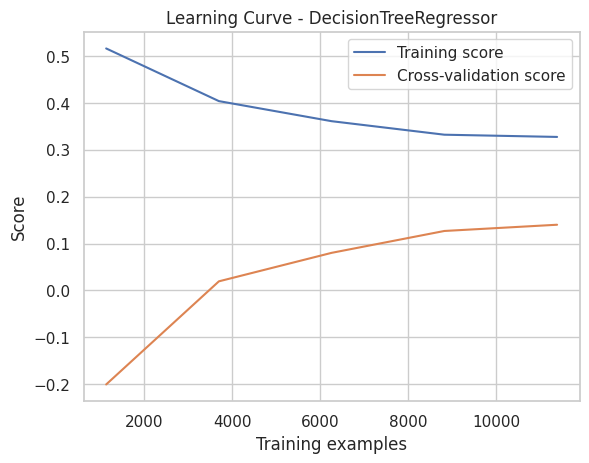

Model: RandomForestRegressor
Mean Squared Error (MSE): 22.25
Root Mean Squared Error (RMSE): 4.72
Mean Absolute Error (MAE): 3.72
R-squared (R2): 0.24


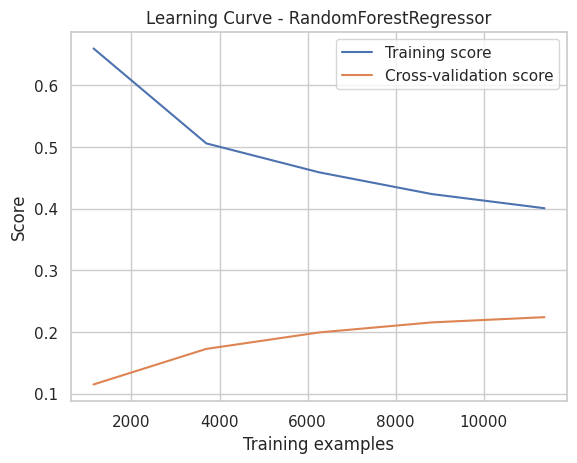

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 20.48
Root Mean Squared Error (RMSE): 4.53
Mean Absolute Error (MAE): 3.52
R-squared (R2): 0.30


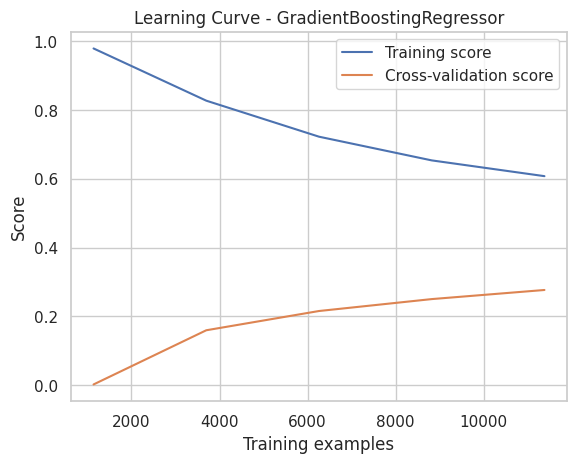

In [64]:
from sklearn.model_selection import learning_curve

# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se crea una lista de modelos a probar
models = [
    SVR(kernel='rbf', C=10, gamma='auto'),
    DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=42),
    RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=42)
]

best_model = None
best_r2 = -float('inf')

for model in models:
    # Se entrena el modelo
    model.fit(X_train, y_train)

    # Se realizan predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Se calculan métricas del modelo
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Se muetsran las métricas del modelo actual
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Se genera una curva de aprendizaje para analizar el sobreajuste
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Se grafica la curva de aprendizaje
    plt.figure()
    plt.title(f"Curva de aprendizaje - {model.__class__.__name__}")
    plt.xlabel("Ejemplos entrenados")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    print("=" * 40)



Se puede observar que, en todos los gráficos, las curvas de aprendizaje se acercan entre sí, y la de validación cruzada está por debajo de la de entrenamiento. Dado esto, es posible que no haya un problema de sobreajuste. Sin embargo, las curvas parecieran tender a converger a puntajes bajos, esto indica que dichos modelos no están captando adecuadamente las características del dataset, tal y como indican el resto de las métricas.

# Pese a todo esto, se concluye que Gradient Boosting Regressor ofrece las mejores métricas en este caso, por lo que se utilizará este modelo.

A continuación se entrena el modelo y se visualiza algunos posibles resultados

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# se entrena el modelo
model = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

In [80]:
for i in range(10):
    print("Ejemplo", i+1)
    print("Características:")
    print(X_test.iloc[i])
    print("Etiqueta:", y_test.iloc[i])  # Utiliza .iloc para acceder a las etiquetas
    print("="*20)


Ejemplo 1
Características:
publisher       1262
genres             2
release_date       7
tags              26
specs             30
early_access       0
developer       1628
sentiment          0
Name: 32064, dtype: int64
Etiqueta: 0.99
Ejemplo 2
Características:
publisher       5210
genres             5
release_date       5
tags             268
specs              3
early_access       0
developer       6698
sentiment         15
Name: 24856, dtype: int64
Etiqueta: 7.49
Ejemplo 3
Características:
publisher       5988
genres            18
release_date       2
tags             135
specs             26
early_access       0
developer       7719
sentiment          0
Name: 30546, dtype: int64
Etiqueta: 2.99
Ejemplo 4
Características:
publisher        228
genres            18
release_date       6
tags              97
specs             29
early_access       0
developer       3708
sentiment         17
Name: 6890, dtype: int64
Etiqueta: 4.99
Ejemplo 5
Características:
publisher       5988
genres   

- Se observa que el modelo ofrece resultados relativamente variados. 
- Ninguno de los modelos obtuvo un valor relativamente alto de r2.
- El RMSE de cada modelo ronda por los valores 4 y 5 aproximadamente, esto nos dice que, teniendo en cuenta el rango intercuartil del conjunto target ( que oscilaba entre 2.99 y 9.99 ), los valores recien presentados de forma aleatoria están entre estos parámetros ( RIC+- 4 o 5).

# Consideraciones para mejoras

- Se podría utilizar la métrica MSLE ( error cuadrático medio logarítmico  ), dado que esta penaliza más los datos más concentrados y no es tan sensible con los outliers.
- Se podría utilizar Get Dummies de one hot encoding, con una computadora que tenga mejores recuros.
- Se podría haber probado utilizar el método de codificación Integer encoding, que no se pudo analizar por falta de tiempo.
- Se podría investigar acerca de la implementación de otros núcleos para el algoritmo SVR, con el fin de obtener mejores métricas para este algoritmo.